# 信号処理のための前処理

ここでは、ベアリングの異常検知を行うための前処理について説明します。

使用するデータは　Case Western University seeded fault bearing dataset で公開されている、ベアリングの振動データであり、このデータは以下のURLにて公開されています。 http://data-acoustics.com/measurements/bearing-faults/

## ベアリングの異常検知とは

そもそもベアリングとは何かという疑問があるかもしれませんが、調べてもわからない方に簡単に説明すると、モータの軸のように回転運動をするものを受け止めて円滑に動力を伝えるためには、軸受が必要となります。その軸受けには大きく分けて「転がり軸受」と「滑り軸受」とがありますが、今回は転がり軸受を対象として異常を検知することを目的とするための前処理に関する説明になります。

この転がり軸受を図に表すと、以下の図のような構成となっており、内側の部品(軸)のことを内レース(Inner race)、外側の部品のことを外レース(Outer race)とよびます。この中のいずれかの部品が故障することにより、異常が発生することになります。

>![代替テキスト](https://jp.images-monotaro.com/pages/productinfo/bearing_comparison/img/01.png) 引用: [モノタロウHP](https://www.monotaro.com/s/pages/productinfo/bearing_comparison/)より

## 分析対象のデータファイルのダウンロード

サイトでは、4種類の振動データが公開されています。

* Normal Baseline Data: 正常時のベアリング振動データ Drive-End と FAN-End のデータのみ (約20秒)
* 12k Drive End Bearing Fault Data: 12k sample per sec で取得した Drive End(DE) Bearing 異常のデータ(約10秒)
* 48k Drive End Bearing Fault Data] 48k sample per sec で取得した Drive End(DE) Bearing 異常のデータ
* Fan-End Bearing Fault Data: Fan-End(FE) 異常のデータ

上記の Drive End, Fan End とは、以下の図のような構成を想定しているものと思われます。
![代替テキスト](https://lh3.googleusercontent.com/BylntdJOJmlANygN-PAylckILaaZpJ8CJr5gcNztp6uvzp4-KsNfsoqc8OUWrqFbzthuEAcxTn9Iel5HpJsh6wRfoUqR-2mwaE9TA7mU7KyDwdL88BOGDIUK9AZjgayIXmU_qrrbzt4R8jFq20-Ze9kawyCzM7dHUnyd0S4XSkv0MiIYabj20AfCRqqqcIVUffOyxpIWY9RDdda7rqu5vFjr0ul5Z3ILm1y5oHMaNnH_bxSTXYNmktRkMZCXnxbcMqow8tJSN0N-qlQkpJkFW8DDWs49qFqCW2KCyMgYBIvPflJUTrI6BbLxEe7Iw5wOt9Qd60IbvzRYo-zCxKeQk2FY6XF2O0LIxKCdbIMTYAZt3JElxS8f5y21pQGJSSCl54LTvQ8qWEfPXRhkHGGmx2h6316vXKLAMbQM93VkoshpD46yIMc92Zh-QRxYGjFXTFGZNgLE1FW_ROOhkLeD1Bs7YANAWhOEzLcS9p2kH0vt0BFFH7pPPXCw50LeYJmJbMCgXOYVDuAloHWjFBAw2ld1gDwZI5QbAWFmgDB96TA7NYkKPPnKDuhP6xXp01kijaW42WLaR4-Zsx6Icl134FUkNSK-X30YjI-VZikNXPFWVyia3Qrve8q5dbPyvur-P0rf7JHv1kRdjqpVoIJsl4FM=w500-no)

* DE - drive end accelerometer data
* FE - fan end accelerometer data
* BA - base accelerometer data

そして、それぞれのファイルでは Motor Load (HP:馬力)ごとの振動データが含まれており、特に異常データには、内外のレースならびにボールの振動データが Fault Diameter (異常の大きさ？) ごとに公開されている。

そのため、データから、DE or FE どちらの異常であるのか、またはその異常の大きさ?のクラス分けなども可能なデータとおもわれます。

... 理解が間違っていなければ

## 正常データ・異常データのファイルのダウンロード

まずは、ファイル名一覧からファイルをダウンロードする関数を作成します。ファイルはすべて同じフォルダに用意されており、数値.mat という形式で保存されていることから、URL を生成して、任意のフォルダにダウンロードする関数とします


In [0]:
import urllib.request

url = 'http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/' # ダウンロードURL
data_path = './sample_data'                                                              # 保存ディレクトリ

# ファイル名の一覧を与えてダウンロードする関数
def download(lst):
  for n in lst:
    print("{}.mat".format(n))
    urllib.request.urlretrieve("{}{}.mat".format(url,n),'{}/{}.mat'.format(data_path,n))

In [0]:
true_f = ['097', '098', '099', '100']
false_f_in_007 = ['105','106','107','108']
false_f_in_014 = ['169','170','171','172']
false_f_in_021 = ['209','210','211','212']

というのを一つ一つ行うのは面倒なので、github 上にファイルをまとめたものをあげてあるので、そちらをダウンロードすることにします。

In [0]:
!git clone https://github.com/k4noinfo/Bearing_Fault_Data.git

Cloning into 'Bearing_Fault_Data'...
remote: Enumerating objects: 79, done.
remote: Total 79 (delta 0), reused 0 (delta 0), pack-reused 79
Unpacking objects: 100% (79/79), done.
Checking out files: 100% (68/68), done.


このダウンロードしたファイルは、正常データ Normal と Drive End の故障データ \{DE_0HP ～ DE3HP}, Fan End の故障データ \{FE_0HP ～ 3HP} のフォルダで構成されている、0HP ～ 3HP は、モーターのトルク(HP: 馬力)で大まかに分けられており、 故障データのフォルダには、破損のサイズ\{007, 014, 021} と、センサデータの箇所?{IR: InnerRace, B: Ball, OR: OuterRace} でファイル名が構成されている。

今回は、異常検知を行うため、Normal のデータと故障データのいずれかのファイルを使用することになります。例えば、DE の異常検知を行うのであれば、Normal フォルダにあるいずれかの HP のファイルと、同じHPのDEフォルダにあるデータを使用します。

他にはどの程度の破損が生じているのかを検知したいのであれば、同じHPの故障の大きさの異なるファイルをラベル付けして分類する課題になります。

### ダウンロードしたファイルから時系列データの抽出

In [0]:
from scipy import io
import pandas as pd
import re

def load_data(dir, f_name, position='DE'):
  df = pd.DataFrame()
  
  file_n = '{}/{}.mat'.format(dir,f_name)
  print(file_n)
  matdata = io.loadmat(file_n, squeeze_me=True)
  tmp_data = pd.DataFrame()
 
  for key in matdata.keys():
    if position == 'DE' or 'ALL':
      DE = re.match('X\d{3}_DE_time', key)
      if DE:
        tmp_data['DE_time'] = matdata[key]
        print('DE: ',len(tmp_data['DE_time']))  
    if position == 'BA'  or 'ALL':
      BA = re.match('X\d{3}_BA_time', key) 
      if BA:
        tmp_data['BA_time'] = matdata[key]
        print('BA: ',len(tmp_data['BA_time']))
    if position == 'FE'  or 'ALL':
      FE = re.match('X\d{3}_FE_time', key)
      if FE:
        tmp_data['FE_time'] = matdata[key]
        print('FE: ',len(tmp_data['FE_time']))
  df = pd.concat([df, tmp_data],ignore_index=True)
  return df

In [0]:
data = load_data('/content/Bearing_Fault_Data/Normal','normal_0_097','ALL')

/content/Bearing_Fault_Data/Normal/normal_0_097.mat
DE:  243938
FE:  243938


In [0]:
data

,DE_time,FE_time
0,0.053197,0.145667
1,0.088662,0.097796
2,0.099718,0.054856
3,0.058621,0.036982
4,-0.004590,0.054445
5,-0.056952,0.021162
6,-0.071764,-0.003698
7,-0.058621,-0.010684
8,-0.046521,0.029380
9,-0.049859,0.104576


### 元信号の確認

読み込んだデータには DE_time と FE_time という２つの時系列データが含まれています。このデータはベアリングの振動データになります。

この時系列データは(1軸？)加速度センサのデータとなり、サンプリングレートは DE(Drive End)は12000/sec と 48000/sec のもの、FE(FUN END)は12000/secのセンサで取得されたものです。 

In [0]:
data.head()

,DE_time,FE_time
0,0.053197,0.145667
1,0.088662,0.097796
2,0.099718,0.054856
3,0.058621,0.036982
4,-0.004590,0.054445


このデータをグラフにプロットすると次のような波形であることがわかります

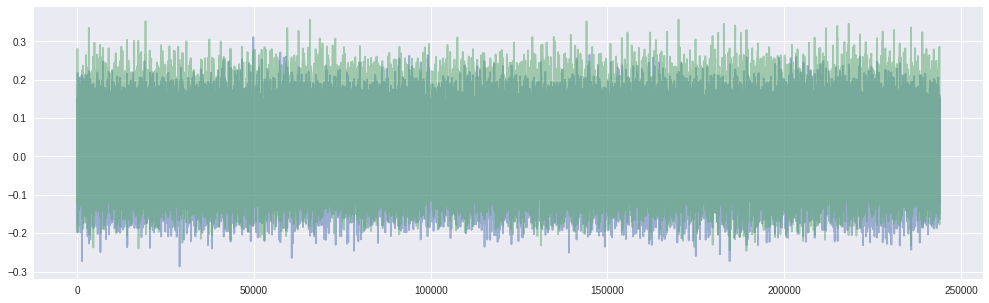

In [0]:
from matplotlib import pyplot as plt

plt.figure(figsize=(17,5))
plt.plot(data, alpha=0.5)

このデータはデータ点数がそれでも25万点近い数値であることから20秒程度の期間の信号になります。モーターが約1800RPMであることから回転2周期が400(=120000/(1800/60))サンプル、約1波長分の区間である800点に絞ると以下のような波であることがわかります。


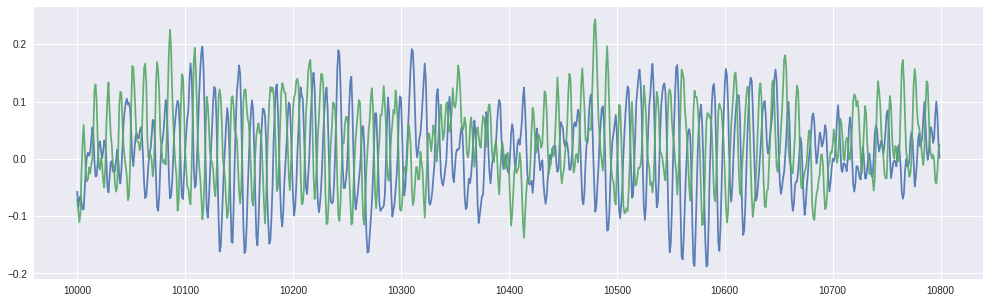

In [0]:
plt.figure(figsize=(17,5))
plt.plot(data[10000:10800], alpha=0.9)

上の図から、視覚的に、細かい波と、大きな波の流れから構成されているというのが見て取れるが、どのような周期の波で構成されているのか確認するため、ローパスフィルタ(高周波成分=細かい振動を取り除く処理)の一つである、移動平均を求める関数 rollong を使用して波形を確認(移動幅:12, 120)すると以下のようになる。

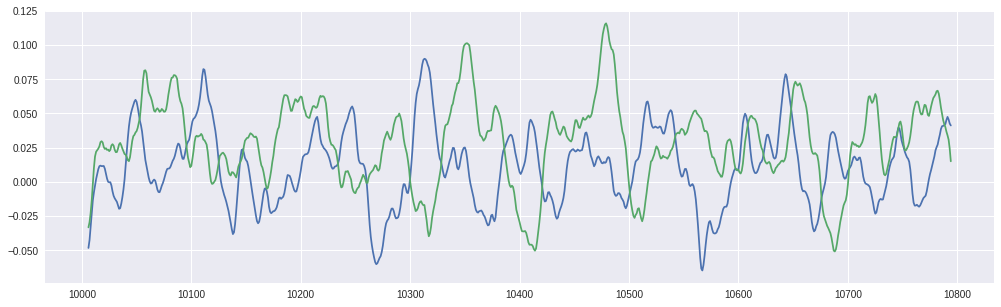

In [0]:
plt.figure(figsize=(17,5))
plt.plot(data[10000:10800].rolling(12,center=True).mean())

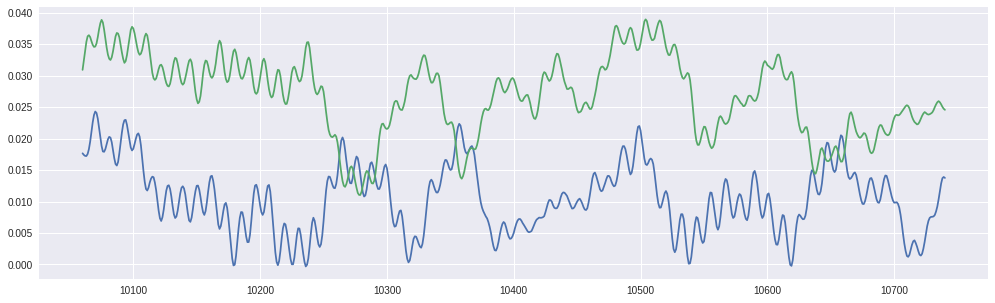

In [0]:
plt.figure(figsize=(17,5))
plt.plot(data[10000:10800].rolling(120,center=True).mean())

このような複数の波から構成される理由としては、部品の材質などによって生じる振動の伝搬、減衰が、部品の連結関係からどのように伝搬するかで、共振を生じたり、相殺したりするためである。

部品が正常に動作しているときの振動のパターンと、劣化や異常をきたした場合の振動のパターンが異なることを利用して、故障部品を特定することを異常検知という。

## 信号処理のための前処理の手順

まず、波形データの特徴量には大きく切り分けて、**時間領域**のデータと**周波数領域**のデータの２種類があります。時間領域のデータとは、加速度センサなどで得られた時系列データそのものになります。それに対して、周波数領域のデータとは、波に含まれている周波数成分で表現したデータになります。そのため、フーリエ変換などをもちいて周波数成分の抽出を行う必要があります。

このように波形データは様々な成分の波から構成されているため、時間領域・周波数領域のデータを単純に特徴量化すると、異なる波の成分を持ちながら同一の特徴量を持つデータが多数存在する可能性が出てきます。そこで、それらを求める前に、区間信号に対してバンドパスフィルタを適用したデータを生成して、それらも含めて特徴量を求めることが必要となります。


そのため、以下のような手順で前処理を行う必要がある。

まずは信号をフーリエ変換するなどして周波数領域の情報に変換する

1.   原信号のノイズを除去する
2.   原信号を任意の区間で分割する
3.   分割した区間信号にたいして、いくつかの領域に分けたバンドパスフィルタを適用することで、特定の周波数成分ごとのデータを作成する。
4.   3で生成した区間信号に対してフーリエ変換を行うことで、各信号の周波数領域の情報を生成する。
5.   各区間信号に対して、時間領域、周波数領域の情報に対して特徴量を求めて、説明変数のベクトルを生成する

これらの処理を、正常データ、異常データに対して行い、特徴量ごとにラベル付けを行い、訓練用データと、テストデータに分ける。



## 正常データと異常データの読み込み

In [0]:
true_data = load_data('/content/Bearing_Fault_Data/Normal','normal_0_097')
false_data = load_data('/content/Bearing_Fault_Data/DE_0HP','12k_DE_IR007_0_105')

/content/Bearing_Fault_Data/Normal/normal_0_097.mat
DE:  243938
FE:  243938
/content/Bearing_Fault_Data/DE_0HP/12k_DE_IR007_0_105.mat
DE:  121265
FE:  121265
BA:  121265


# ノイズの除去

振動データには、センサなど計測の系のなかで何かしらのノイズが混入します。そのため、ノイズ除去が必要となります。以下では、ノイズ除去はウイナーフィルタを用いて行う。実際には高周波成分を取り除いているだけかも？

In [0]:
import scipy.signal

true_data_f = scipy.signal.wiener(true_data,3)
false_data_f = scipy.signal.wiener(false_data,3)

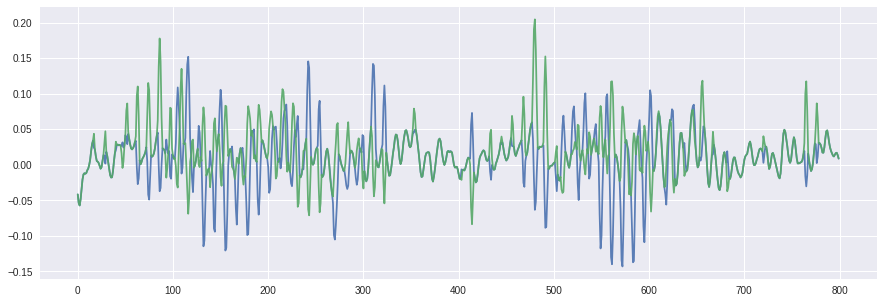

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(true_data_f[10000:10800], alpha=0.9)

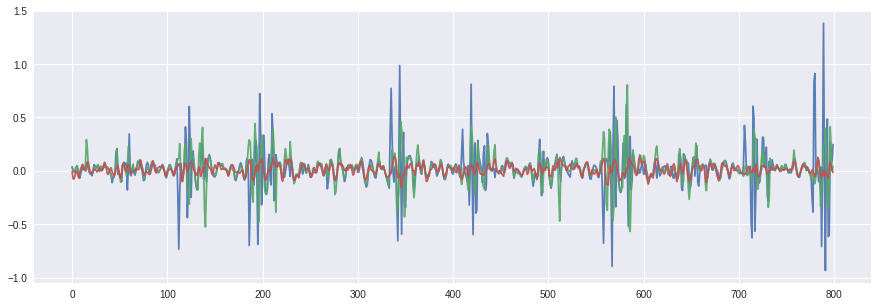

In [0]:
plt.figure(figsize=(15,5))
plt.plot(false_data_f[10000:10800], alpha=0.9)

# データのスライス



In [0]:
!pip install pyprind
import pyprind

In [0]:
import numpy as np
import pyprind

RPM = 1797
sample_rate = 12000
window_base = int((sample_rate)//RPM)

def slice_data(lst,dim):
  emb = np.empty((0,dim),float)
  pbar = pyprind.ProgBar(lst.size//dim)
  for i in range(lst.size//dim):
    if (i+1)*dim > lst.size:
      break
    #print((i+1)*dim)
    tmp = np.array(lst[i*dim:(i+1)*dim])[::-1].reshape((1,-1))
    emb = np.append(emb, tmp, axis=0)
    pbar.update()
  return emb

In [0]:
true_data_f

array([[0.04281357, 0.04281357],
       [0.05998851, 0.05998851],
       [0.04851502, 0.04851502],
       ...,
       [0.00951245, 0.07150587],
       [0.03947326, 0.03947326],
       [0.02770651, 0.02770651]])

In [0]:
true_data_f[:,0]

array([0.04281357, 0.05998851, 0.04851502, ..., 0.00951245, 0.03947326,
       0.02770651])

In [0]:
true_data_DE = slice_data(true_data_f[:,0], window_base*10)
false_data_DE = slice_data(false_data_f[:,0], window_base*10)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [0]:
true_data_DE.shape

(4065, 60)

In [0]:
false_data_DE.shape

(2021, 60)

# データの特徴量を求める

ここでは、波形データからの特徴量抽出に関して true_data を用いて作成方法を紹介します。機械学習では、そのまま波形を利用して分析することも可能ですが、それではデータの次元が膨大になるため、次元圧縮もかねて特徴量をもとめて、それをもとにデータの分類、評価などを行います。



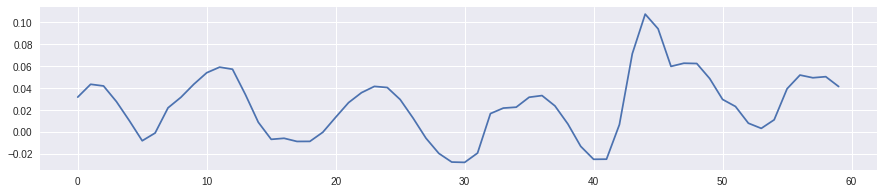

In [0]:
target_data = true_data_DE[150]
plt.figure(figsize=(15,3))
plt.plot(target_data)

## 特徴量(実効値・最大値、波高率・歪度・尖度)の計算

実効値は、各信号の値の二乗値の平均をルートしたものである。

> $実効値 = \sqrt{\frac{1}{T}\int_0^Tx(t)^2}$


In [0]:
rms = np.sqrt(np.mean(target_data**2))
rms

0.03795668420863941

In [0]:
max = np.max(target_data)
max

0.10753720713811353

波高率は、実効値を平均値で割った値になります。
​
> $波高率 = \frac{実効値}{平均値}$

In [0]:
rms/np.mean(target_data)

1.576724458125449

歪度、尖度は、scipy.stats にある skew 関数、 kurtosis 関数を使って求めることができる

In [0]:
import scipy
scipy.stats.skew(target_data)

0.2894574315282248

In [0]:
scipy.stats.kurtosis(target_data)

-0.038194294227871683

変調度とはエンベロープ処理をした後の実効値のことである

In [0]:
import scipy.signal
envelope = abs(scipy.signal.hilbert(target_data))

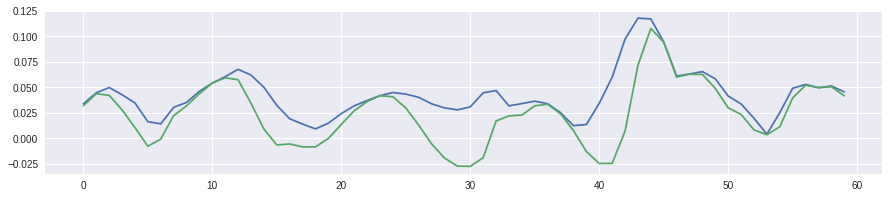

In [0]:
plt.figure(figsize=(15,3))
plt.plot(envelope)
plt.plot(target_data)

In [0]:
modulation = np.sqrt(np.mean(envelope**2))
modulation

0.047978036252963686

これらをまとめると以下のような関数として定義できる

In [0]:
import scipy.stats
import scipy.signal

def getSignalFeature(signal):
  rms = np.sqrt(np.mean(signal**2))
  max_v = np.max(signal)
  peak_ratio = rms / np.mean(signal)
  skew = scipy.stats.skew(signal)
  kurt = scipy.stats.kurtosis(signal)
  envelope = abs(scipy.signal.hilbert(signal))
  modul = np.sqrt(np.mean(envelope**2))
  return np.array([rms, max_v,peak_ratio, skew, kurt, modul])
 

In [0]:
getSignalFeature(target_data)

array([ 0.03795668,  0.10753721,  1.57672446,  0.28945743, -0.03819429,
        0.04797804])

# 周波数領域データの特徴量: フーリエ変換

信号の周波数領域を取得するため、時間領域での特徴量を求めたときと同じ信号をまずはフーリエ変換する。フーリエ変換は numpy の fft.fft 関数で実行可能である。

In [0]:
import numpy as np
target_data_fft = np.fft.fft(target_data, axis=-1, norm=None)

フーリエ変換で得られるのは、周波数の実数部と虚数部の値になります。実数部とは、周波数成分(振動周期)にあたり、虚数部は位相(sin波の遅れなど波の状況)を表しています

In [0]:
target_data_fft[:5]

array([ 1.44438747+0.j        ,  0.43094591+0.2656128j ,
       -0.27450271+0.0697948j , -0.0283393 -0.25398179j,
        0.11011589+0.08610064j])

## 周波数の確認

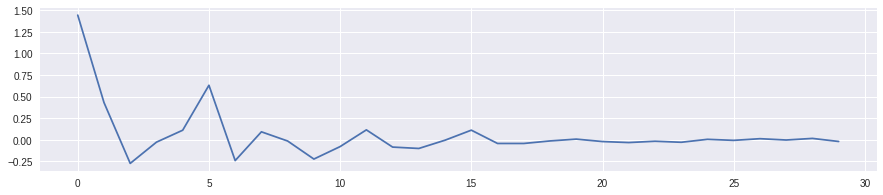

In [0]:
plt.figure(figsize=(15,3))
plt.plot(target_data_fft.real[:len(target_data)//2])

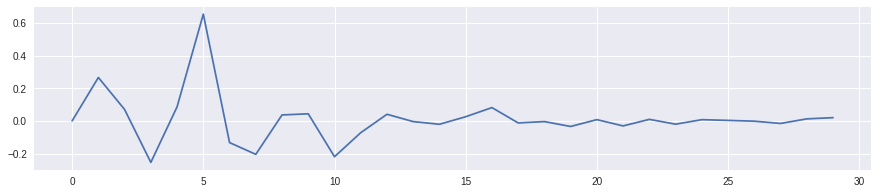

In [0]:
plt.figure(figsize=(15,3))
plt.plot(target_data_fft.imag[:len(target_data)//2])

## 特徴量(実効値・最大値、波高率・歪度・尖度)の計算

実効値は、各信号の値の二乗値の平均をルートしたものである。

> $実効値 = \sqrt{\frac{1}{T}\int_0^Tx(t)^2}$


In [0]:
rms = np.sqrt(np.mean(target_data_fft.real**2))
rms

0.2509940788021983

In [0]:
max = np.max(target_data_fft.real)
max

1.4443874709890294

波高率は、実効値を平均値で割った値になります。

> $波高率 = \frac{実効値}{平均値}$

In [0]:
rms/np.mean(target_data_fft.real)

7.888850766346324

歪度、尖度は、scipy.stats にある skew 関数、 kurtosis 関数を使って求めることができる

In [0]:
import scipy
scipy.stats.skew(target_data_fft.real)

3.490664936816635

In [0]:
scipy.stats.kurtosis(target_data_fft.real)

15.781252424183844

これらは、基本的に時間領域での特徴量と同じものになるため、先ほど定義した関数 getSignalFeatureを使って求めても同じである

In [0]:
getSignalFeature(target_data_fft.real)

array([ 0.25099408,  1.44438747,  7.88885077,  3.49066494, 15.78125242,
        0.3524398 ])

# 信号データに対するバンドパスフィルタの適用

バンドパスフィルタとして FIR を用いる。

窓関数として blackman を適用。

何が一番いいのかは不明

## 人工波形に対するフィルタの適用
フィルタを適応するとは、どういうことか知らない方に向けて、まずはわかりやすいように人工波形を用いて説明をする。

以下では、まず、周期10, 40, 60, 150, 300 の波を合成する。波とは基本的に $sin$ 関数で表現できる。この $sin$ 関数の１周期の長さとその強さから、基本的な波は形成される。それらの周期、強さ、位相が異なる波が複数重なって**合成**されたもので波が再現可能であると考えられている。よって、下記のコードにあるように複数の sin 関数の足し算(合成)で波を再現できる。

In [0]:
import numpy as np

N=400
dt = 0.001
f1, f2, f3, f4, f5 = 10, 40 , 60, 150, 300

t = np.arange(0, N*dt, dt)
x = 3*np.sin(2*np.pi*f1*t) + 0.3*np.sin(2*np.pi*f2*t) + 0.2*np.sin(2*np.pi*f3*t) + 0.5*np.sin(2*np.pi*f4*t) + 2*np.sin(2*np.pi*f5*t)

上記に定義した波 x をグラフにプロットすると以下のようになる

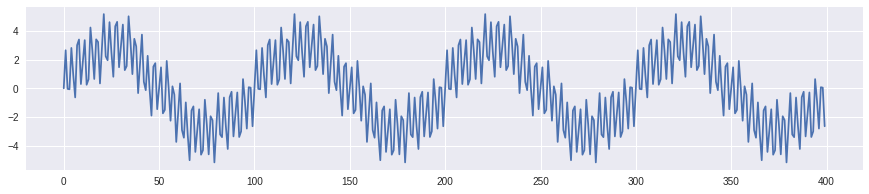

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.plot(x)

低周波に、細かい振動をもつ高周波が合成されていることがよくわかる。

この波に対して、フィルターを適応するにはいくつかの方法があるが、今回はFIRフィルタを用いる方法を示す。

FIEフィルタの関数として scipy では scipy.signal.firwin 関数が用意されている。この関数を用いるにはタップと呼ばれる波を吸収する仕組みの段数(numtaps: 奇数である必要がある)と、カットの区切り、サンプリングレートfs に、信号を通過させるかどうかのオプション pass_zero を定義する必要がある。

周期65以下の低周波をカットする場合には、以下のコードのように記述して、そこから得られた波の状況は以下のグラフのようになる。

In [0]:
import scipy.signal

filter1 = scipy.signal.firwin(numtaps=21, cutoff=65, fs=1/dt, pass_zero=False)
y1 = scipy.signal.lfilter(filter1, 1, x)

F1 = np.fft.fft(y1)
Amp1 = np.abs(F1/(N/2))

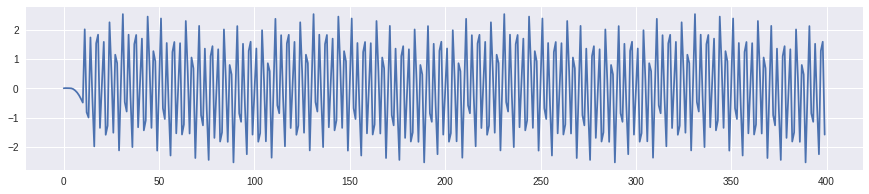

In [0]:
plt.figure(figsize=(15,3))
plt.plot(y1)

逆に、高周波の波をカットする場合には、pass_zero を反転させて適用するだけでよい。

In [0]:
filter2 = scipy.signal.firwin(numtaps=21, cutoff=40, fs=1/dt, pass_zero=True)
y2 = scipy.signal.lfilter(filter2, 1, x)

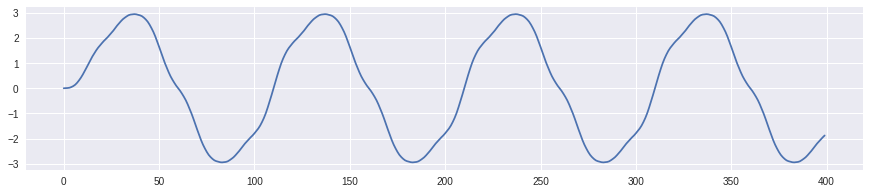

In [0]:
plt.figure(figsize=(15,3))
plt.plot(y2)

## bearing データへのフィルタの適用

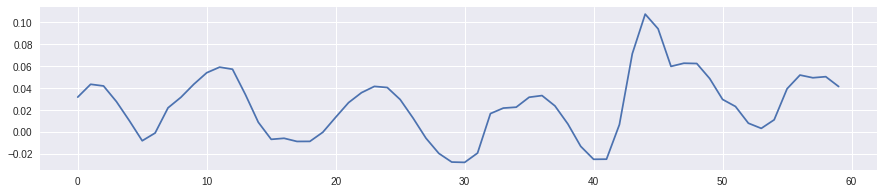

In [0]:
target_data = true_data_DE[150]
plt.figure(figsize=(15,3))
plt.plot(target_data)

In [0]:
import scipy.signal


fs = 12000
fc = [6, 12, 60, 120, 600, 1200, 5999]
taps = 5
filter1 = scipy.signal.firwin(numtaps=taps, cutoff=fc[0:2], fs = fs, pass_zero=False)
filter2 = scipy.signal.firwin(numtaps=taps, cutoff=fc[1:3], fs = fs, pass_zero=False)
filter3 = scipy.signal.firwin(numtaps=taps, cutoff=fc[2:4], fs = fs, pass_zero=False)
filter4 = scipy.signal.firwin(numtaps=taps, cutoff=fc[3:5], fs = fs, pass_zero=False)
filter5 = scipy.signal.firwin(numtaps=taps, cutoff=fc[4:6], fs = fs, pass_zero=False)
filter6 = scipy.signal.firwin(numtaps=taps, cutoff=fc[5:7], fs = fs, pass_zero=False)

#filter1 = scipy.signal.firwin(numtaps=N, cutoff=[fc6,fc7], fs = fs, pass_zero=False)
y1 = scipy.signal.lfilter(filter1, 1, target_data)
y2 = scipy.signal.lfilter(filter2, 1, target_data)
y3 = scipy.signal.lfilter(filter3, 1, target_data)
y4 = scipy.signal.lfilter(filter4, 1, target_data)
y5 = scipy.signal.lfilter(filter5, 1, target_data)
y6 = scipy.signal.lfilter(filter6, 1, target_data)

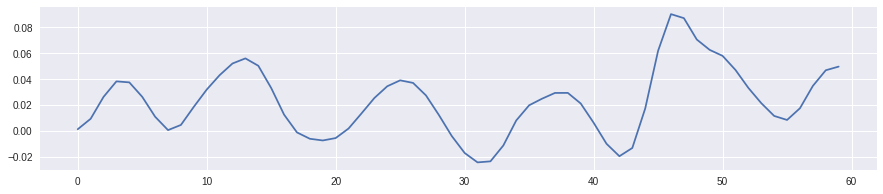

In [0]:
plt.figure(figsize=(15,3))
plt.plot(y1)

それぞれのフィルタを適用した波を重ねて表示すると以下のようになる

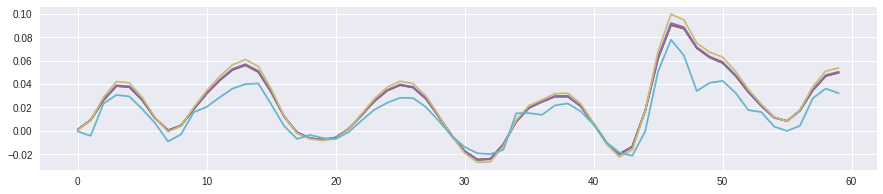

In [0]:
plt.figure(figsize=(15,3))
plt.plot(y1)
plt.plot(y2)
plt.plot(y3)
plt.plot(y4)
plt.plot(y5)
plt.plot(y6)


このように、構成する波が特定の周波に偏っていることが、フィルタした結果からもわかる。

In [0]:
target_data = false_data_DE[100]

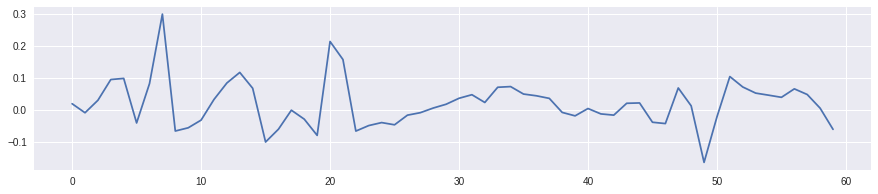

In [0]:
plt.figure(figsize=(15,3))
plt.plot(target_data)

In [0]:
import scipy.signal

fs = 12000
fc = [6, 12, 60, 120, 600, 1200, 5999]
taps = 5
filter1 = scipy.signal.firwin(numtaps=taps, cutoff=fc[0:2], fs = fs, pass_zero=False)
filter2 = scipy.signal.firwin(numtaps=taps, cutoff=fc[1:3], fs = fs, pass_zero=False)
filter3 = scipy.signal.firwin(numtaps=taps, cutoff=fc[2:4], fs = fs, pass_zero=False)
filter4 = scipy.signal.firwin(numtaps=taps, cutoff=fc[3:5], fs = fs, pass_zero=False)
filter5 = scipy.signal.firwin(numtaps=taps, cutoff=fc[4:6], fs = fs, pass_zero=False)
filter6 = scipy.signal.firwin(numtaps=taps, cutoff=fc[5:7], fs = fs, pass_zero=False)

#filter1 = scipy.signal.firwin(numtaps=N, cutoff=[fc6,fc7], fs = fs, pass_zero=False)
y1 = scipy.signal.lfilter(filter1, 1, target_data)
y2 = scipy.signal.lfilter(filter2, 1, target_data)
y3 = scipy.signal.lfilter(filter3, 1, target_data)
y4 = scipy.signal.lfilter(filter4, 1, target_data)
y5 = scipy.signal.lfilter(filter5, 1, target_data)
y6 = scipy.signal.lfilter(filter6, 1, target_data)

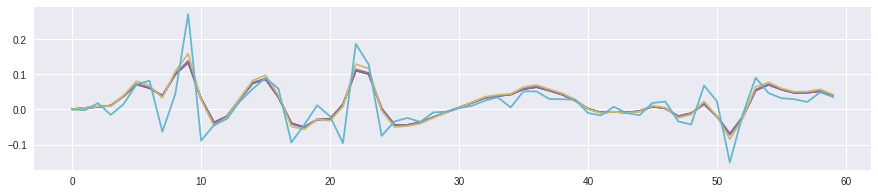

In [0]:
plt.figure(figsize=(15,3))
plt.plot(y1)
plt.plot(y2)
plt.plot(y3)
plt.plot(y4)
plt.plot(y5)
plt.plot(y6)

このように、異常値を含むデータでは、正常データとは異なり高周波成分に大きなばらつきが生じていることがわかる。

# Bearing Data からの訓練・テストデータの生成

ここまで、区間データにスライスした時系列データをもとに、特徴量の算出、周波数領域のデータへの変換、特定の周波数を含むデータへ変換するためのフィルタの適応について説明しました。これらを以下の順に適応して、一つの区間データの特徴量を生成します。

1. ノイズ除去をする
2. 時系列データを一定区間でスライスする。
3. バンドパスフィルタを適用して、「なし、6～12, 12～60, 60～120, 120～600, 600～1200, 1200～5999」を適用したデータの7種類生成する。
4. 1で生成したデータからそれぞれ周波数領域の情報に変換する
5. 1, 2 で生成した計14種類のデータに対して特徴量を求める。

上記の処理を行うことで、一つの区間データに対して 84 次元( = 14 x 6) の特徴量が生成される。生成されたデータに対して、ラベルを加えることで、訓練と評価に用いるデータの集合が生成される。

今回は、異常検知であることから、正常データで訓練して、異常値の検知ができるように、まずは正常データから訓練データを生成して、異常値と正常データを混ぜて評価データを生成します。その際、評価データのクラスが均衡になるように、正常データを半分(10秒分)を訓練データとして、残りの10秒を異常データとまぜることで評価データとします。

ここまで、手順の2までは true_data_DE, false_data_DE として生成しているため、フィルタを適用した信号データを生成する。

## フィルタの適応

In [0]:
import scipy.signal

fs = 12000
fc = [6, 12, 60, 120, 600, 1200, 5999]
taps = 5
filter1 = scipy.signal.firwin(numtaps=taps, cutoff=fc[0:2], fs = fs, pass_zero=False)
filter2 = scipy.signal.firwin(numtaps=taps, cutoff=fc[1:3], fs = fs, pass_zero=False)
filter3 = scipy.signal.firwin(numtaps=taps, cutoff=fc[2:4], fs = fs, pass_zero=False)
filter4 = scipy.signal.firwin(numtaps=taps, cutoff=fc[3:5], fs = fs, pass_zero=False)
filter5 = scipy.signal.firwin(numtaps=taps, cutoff=fc[4:6], fs = fs, pass_zero=False)
filter6 = scipy.signal.firwin(numtaps=taps, cutoff=fc[5:7], fs = fs, pass_zero=False)


In [0]:
true_data_f1 = scipy.signal.lfilter(filter1, 1, true_data_DE)
true_data_f2 = scipy.signal.lfilter(filter2, 1, true_data_DE)
true_data_f3 = scipy.signal.lfilter(filter3, 1, true_data_DE)
true_data_f4 = scipy.signal.lfilter(filter4, 1, true_data_DE)
true_data_f5 = scipy.signal.lfilter(filter5, 1, true_data_DE)
true_data_f6 = scipy.signal.lfilter(filter6, 1, true_data_DE)

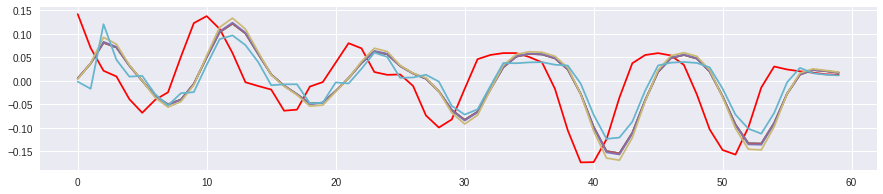

In [0]:
import matplotlib.pyplot as plt
n = 1
plt.figure(figsize=(15,3))
plt.plot(true_data_DE[n],color="r")
plt.plot(true_data_f1[n])
plt.plot(true_data_f2[n])
plt.plot(true_data_f3[n])
plt.plot(true_data_f4[n])
plt.plot(true_data_f5[n])
plt.plot(true_data_f6[n])

In [0]:
false_data_f1 = scipy.signal.lfilter(filter1, 1, false_data_DE)
false_data_f2 = scipy.signal.lfilter(filter2, 1, false_data_DE)
false_data_f3 = scipy.signal.lfilter(filter3, 1, false_data_DE)
false_data_f4 = scipy.signal.lfilter(filter4, 1, false_data_DE)
false_data_f5 = scipy.signal.lfilter(filter5, 1, false_data_DE)
false_data_f6 = scipy.signal.lfilter(filter6, 1, false_data_DE)

## 周波数領域のデータを生成する

In [0]:
import numpy as np
true_data_DE_fft = np.fft.fft(true_data_DE, axis=-1, norm=None)
true_data_f1_fft = np.fft.fft(true_data_f1, axis=-1, norm=None)
true_data_f2_fft = np.fft.fft(true_data_f2, axis=-1, norm=None)
true_data_f3_fft = np.fft.fft(true_data_f3, axis=-1, norm=None)
true_data_f4_fft = np.fft.fft(true_data_f4, axis=-1, norm=None)
true_data_f5_fft = np.fft.fft(true_data_f5, axis=-1, norm=None)
true_data_f6_fft = np.fft.fft(true_data_f6, axis=-1, norm=None)

In [0]:
false_data_DE_fft = np.fft.fft(false_data_DE, axis=-1, norm=None)
false_data_f1_fft = np.fft.fft(false_data_f1, axis=-1, norm=None)
false_data_f2_fft = np.fft.fft(false_data_f2, axis=-1, norm=None)
false_data_f3_fft = np.fft.fft(false_data_f3, axis=-1, norm=None)
false_data_f4_fft = np.fft.fft(false_data_f4, axis=-1, norm=None)
false_data_f5_fft = np.fft.fft(false_data_f5, axis=-1, norm=None)
false_data_f6_fft = np.fft.fft(false_data_f6, axis=-1, norm=None)

## それぞれの信号データに対して特徴量をもとめる

In [0]:
import scipy.stats
import scipy.signal
import pyprind

def getSignalFeature(signal):
  rms = np.sqrt(np.mean(signal**2))
  max_v = np.max(signal)
  peak_ratio = rms / np.mean(signal)
  skew = scipy.stats.skew(signal)
  kurt = scipy.stats.kurtosis(signal)
  envelope = abs(scipy.signal.hilbert(signal))
  modul = np.sqrt(np.mean(envelope**2))
  return np.array([rms, max_v,peak_ratio, skew, kurt, modul])

def getSignalFeatures(*data):
  pbar = pyprind.ProgBar(len(data))
  features = np.array([])
  for d in data:
    tmp = np.array([])
    for i in range(len(d)):
      if tmp.shape == (0,):
        tmp = getSignalFeature(d[i])
      else:
        tmp = np.vstack((tmp, getSignalFeature(d[i])))
    if features.shape == (0,):
      features = tmp
    else:
      features = np.hstack((features, tmp))
    pbar.update()
  return features

In [0]:
true_features = getSignalFeatures(true_data_DE, true_data_f1, true_data_f2, true_data_f3, true_data_f4, true_data_f5, true_data_f6,
                        true_data_DE_fft.real, true_data_f1_fft.real, true_data_f2_fft.real, true_data_f3_fft.real, true_data_f4_fft.real, true_data_f5_fft.real, true_data_f6_fft.real)
false_features = getSignalFeatures(false_data_DE, false_data_f1, false_data_f2, false_data_f3, false_data_f4, false_data_f5, false_data_f6,
                        false_data_DE_fft.real, false_data_f1_fft.real, false_data_f2_fft.real, false_data_f3_fft.real, false_data_f4_fft.real, false_data_f5_fft.real, false_data_f6_fft.real)

0% [##############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:32
0% [##############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


In [0]:
print(true_features.shape)
print(false_features.shape)

(4065, 84)
(2021, 84)


生成した特徴量ベクトルを CSV ファイルに保存するには numpy の savetxt 関数を利用します

In [0]:
np.savetxt('true_features.csv', true_features, delimiter=',')
np.savetxt('false_features.csv', false_features, delimiter=',')

## 訓練データと評価データの作成

訓練・評価データを生成するにあたり、正解不正解のラベルをまずは作成します。

In [0]:
import numpy as np
y_true_label = np.ones(len(true_features))
y_false_label = np.ones(len(false_features)) * -1

In [0]:
y_false_label

array([-1., -1., -1., ..., -1., -1., -1.])

In [0]:
print(y_true_label.shape)
print(y_false_label.shape)

(4065,)
(2021,)


正常データの半分を訓練用データとして、残り半分を異常データと混ぜて評価データとする

In [0]:
X_train = true_features[:2000]
y_train = y_true_label[:2000]

X_test = np.vstack((true_features[2000:4000], false_features[:2000]))
y_test = np.hstack((y_true_label[2000:4000], y_false_label[:2000]))

テストデータは偏っていても問題はないが、なんとなくシャッフルすることにする。

In [0]:
p = np.random.permutation(len(X_test))
X_test = X_test[p]
y_test = y_test[p]

In [0]:
np.savetxt('X_train.csv', X_train, delimiter=',')
np.savetxt('y_train.csv', y_train, delimiter=',')
np.savetxt('X_test.csv', X_test, delimiter=',')
np.savetxt('y_test.csv', y_test, delimiter=',')

# (参考)スペクトルの分析

### 周波数軸の値を計算

In [0]:
signal_freq = np.fft.fftfreq(N, d=1.0/(N/2))

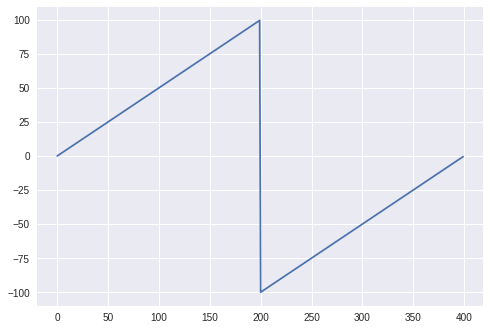

In [0]:
plt.plot(signal_freq)

### 振幅スペクトル

In [0]:
amplitudeSpectrum = [np.sqrt(c.real ** 2 + c.imag ** 2) for c in signal_DE_fft]

[0, 100.0, 0, 0.08]

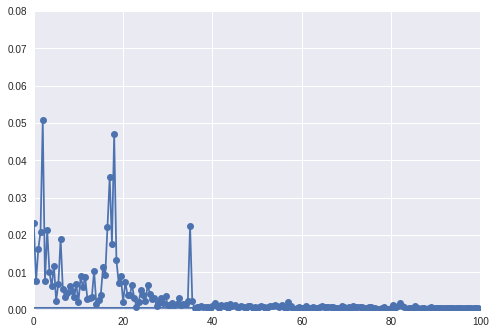

In [0]:
plt.plot(signal_freq, amplitudeSpectrum, marker= 'o', linestyle='-')
plt.axis([0, (N/2)/2, 0, 0.08] )

### 位相スペクトル

In [0]:
 phaseSpectrum = [np.arctan2(int(c.imag), int(c.real)) for c in signal_DE_fft]

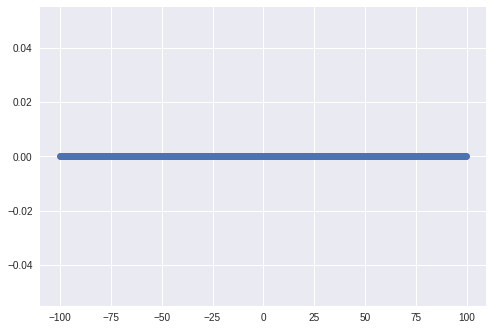

In [0]:
plt.plot(signal_freq, phaseSpectrum, marker= 'o', linestyle='-')

# (参考)フィルタ

In [0]:
tf = scipy.fft(h)
mag = scipy.absolute(tf)
phase = scipy.unwrap(scipy.angle(tf)) * 180. / scipy.pi

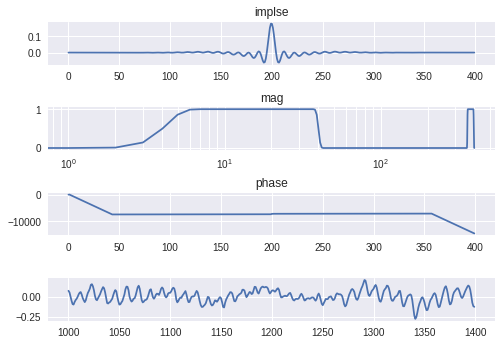

In [0]:
plt.figure()
plt.subplots_adjust(wspace=0.4, hspace=.8)
plt.subplot(4,1,1)
plt.plot(h)
plt.grid('on', 'both')
plt.title('implse')
plt.subplot(4,1,2)
plt.semilogx(mag)
plt.grid('on', 'both')
plt.title('mag')
plt.subplot(4,1,3)
plt.plot(phase)
plt.grid('on', 'both')
plt.title('phase')
plt.subplot(4,1,4)
plt.plot(f)

In [0]:
import scipy
import scipy.signal

N = 400
fs = 12000
nyq = fs / 2.0
fc1 = 6
fc2 = 60
fc3 = 600
fc4 = 5900

h = scipy.signal.firwin(numtaps=N, cutoff=scipy.array([1/(fs/2.), fc1/(fs/2.)]), window='blackman', pass_zero=False)

In [0]:
y1 = scipy.signal.lfilter(h, 1, signal['DE_time'][1400:1800])

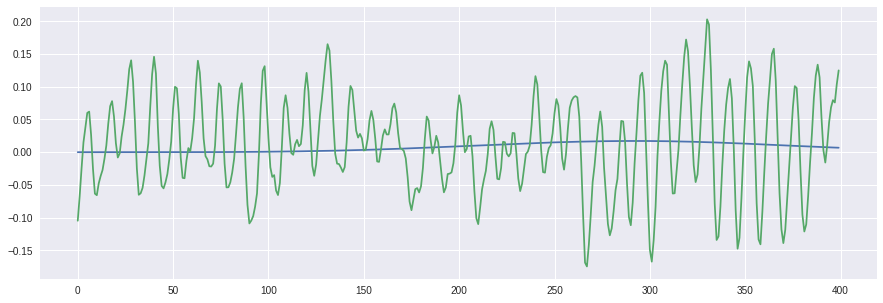

In [0]:
plt.figure(figsize=(15,5))
plt.plot(y1)
plt.plot(range(N), signal['DE_time'][1400:1800])

# (参考) 様々なフィルタ

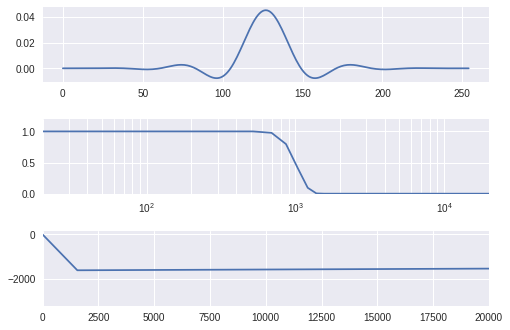

In [0]:
import scipy
import scipy.signal as ss
from matplotlib import pyplot as pp
 
N = 255
fc = 1000.
fc2 = 3000.
Fs = 44100.
 
#%% LPF
h = ss.firwin(numtaps=N, cutoff=fc/(Fs/2.), window='blackman', pass_zero=True)
 
#%% HPF
#h = ss.firwin(numtaps=N, cutoff=fc/(Fs/2.), window='blackman', pass_zero=False)
 
#%% BPF
#h = ss.firwin(numtaps=N, cutoff=scipy.array([fc/(Fs/2.), fc2/(Fs/2.)]), window='blackman', pass_zero=False)
 
#%% BEF
#h = ss.firwin(numtaps=N, cutoff=scipy.array([fc/(Fs/2.), fc2/(Fs/2.)]), window='blackman', pass_zero=True)
 
#%% 表示
f = scipy.array(range(0, N)) * Fs / scipy.double(N)
#f = [scipy.sin(n/10) for n in range(0,N) ]
tf = scipy.fft(h)
mag = scipy.absolute(tf)
phase = scipy.unwrap(scipy.angle(tf)) * 180. / scipy.pi
 
pp.figure()
plt.subplots_adjust(wspace=0.4, hspace=.5)
pp.subplot(3,1,1)
pp.plot(h)
pp.grid('on', 'both')
pp.subplot(3,1,2)
pp.semilogx(f, mag)
pp.xlim([20, 20000])
pp.ylim([0, 1.2])
pp.grid('on', 'both')
pp.subplot(3,1,3)
pp.plot(f, phase)
pp.xlim([0, 20000])
pp.grid('on', 'both')

# Bearing データ処理用クラス

上記の処理をまとめて、ダウンロードしたファイルを読み込み特徴量データを生成するクラスを作成する

In [0]:
# 参考: https://github.com/MrTangsai/BearLSTM/blob/master/Bearclass.py, 
# 参考: https://github.com/yfshich/wdcnn_bearning_fault_diagnosis-master/blob/master/preprocess.py
import scipy.io
import numpy as np
import os
import re

class BearData(object):
  
  def __init__(self, data_dir='data',position='DE'):
    super(Bear2, self).__init__()
    self.data_dir = data_dir
    self.position = position
    self.data = self.getTestData()
    self.target = self.getLabelData()
  
  def _getDataFileList(self):
    return os.listdir(self.data_dir)
  
  def loadDataFiles(self, path):
    
    files = _getDataFileList(self.data_dir)
    data = {}
    for f = in files:
      matdata = scipy.io.loadmat('{}/{}'.format(self.data_dir, f))
      for k = in matdata.keys():
        if position in key:
          data[f] = matdata[k].ravel()
    return data
  
  def slice_data(self, data, slice_rate=0.5):
    for key in data.keys:
      slice_data = data[key]
      total = len(slice_data)
      end_index = int(total * (1 - slice_rate))
      sample_train = int(number * ( 1 - slice_rate))
      if True:
        enc_time = length // enc_step # 864//28
        sample_step = 0
        for j in range(sample_train):
          random_start = np.randam.randint(low=0, high=(end_index - 2 * length))
  
  def getTestData(self):
    files = self._getDataFileList();
    data = None
    #for f_name in files:
    for i in range(len(files)):
      file = scipy.io.loadmat('{}/{}'.format(self.data_dir, files[i]))
      for x in file.keys():
        keys = re.match('X\d{3}_DE_time', x)
        if keys:
          key = keys.group()
          print(files[i])
          print('key: ',key)
      assert len(file[key]) >= 48000
      if i == 0:
        data = np.array(file[key][0:480000]).reshape(2000,240)
      else:
        data = np.vstack((data, np.array(file[key][0:480000]).reshape((2000,240))))
    return data
  
  def getLabelData(self):
    files = self._getDataFileList()
    val = list(map(lambda x: x.replace('.mat',''), files))
    val = np.array(val)[:,np.newaxis]
    target = np.copy(val)
    for _ in range(240):
      target = np.hstack((target, val))
    print(target)
    print(target.shape)
    print(target.flatten())
    return target.flatten()
    
  def save(self):
    scipy.io.savemat('data.mat',{'data': self.data})

SyntaxError: ignored

In [0]:
import os
label = 0
files = os.listdir('./data')
Y = []
for f in files:
  Y+= [label] * 10
  label += 1
Y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9]

In [0]:
!cp -r BearLSTM/data .

In [0]:
bear = Bear2('./data')

B014_3.mat
key:  X192_DE_time
B021_3.mat
key:  X229_DE_time
Normal_3.mat
key:  X100_DE_time
OR014@6_3.mat
key:  X204_DE_time
IR014_3.mat
key:  X177_DE_time
IR007_3.mat
key:  X112_DE_time
IR021_3.mat
key:  X215_DE_time
IR021_3.mat
key:  X217_DE_time
OR007@6_3.mat
key:  X138_DE_time
B007_3.mat
key:  X125_DE_time
OR021@6_3.mat
key:  X241_DE_time
[['B014_3' 'B014_3' 'B014_3' ... 'B014_3' 'B014_3' 'B014_3']
 ['B021_3' 'B021_3' 'B021_3' ... 'B021_3' 'B021_3' 'B021_3']
 ['Normal_3' 'Normal_3' 'Normal_3' ... 'Normal_3' 'Normal_3' 'Normal_3']
 ...
 ['OR007@6_3' 'OR007@6_3' 'OR007@6_3' ... 'OR007@6_3' 'OR007@6_3'
  'OR007@6_3']
 ['B007_3' 'B007_3' 'B007_3' ... 'B007_3' 'B007_3' 'B007_3']
 ['OR021@6_3' 'OR021@6_3' 'OR021@6_3' ... 'OR021@6_3' 'OR021@6_3'
  'OR021@6_3']]
(10, 241)
['B014_3' 'B014_3' 'B014_3' ... 'OR021@6_3' 'OR021@6_3' 'OR021@6_3']


In [0]:
bear.target.shape

(2410,)

In [0]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
target = lb.fit_transform(bear.target)

In [0]:
target

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

# (参考)

In [0]:
!git clone https://github.com/MrTangsai/BearLSTM.git

Cloning into 'BearLSTM'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 36 (delta 8), reused 36 (delta 8), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [0]:
cd BearLSTM

/content/BearLSTM


In [0]:
from Bearclass import *

bear = Bear()

print(bear.data)

[[-0.05277969 -0.00709292  0.05778646 ...  0.02732862  0.051528
   0.070512  ]
 [ 0.08302892  0.10180431  0.11745046 ...  0.10055262  0.05716062
   0.01460308]
 [-0.00584123 -0.01919262 -0.04735569 ...  0.12224862  0.1356
   0.14498769]
 ...
 [ 0.03338667  0.04674133  0.05008    ... -0.030048    0.18112267
   0.38812   ]
 [ 0.55088     0.63768533  0.65938667 ...  0.07845867  0.07094667
   0.0626    ]
 [ 0.03839467  0.03088267  0.06176533 ... -0.277944   -0.20032
  -0.10850667]]


In [0]:
!python main.py

1600 Ellipsis
(1600, 2000) (800, 10) Ellipsis
Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

2019-01-03 09:37:54.777516: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-01-03 09:37:54.777984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2019-01-03 09:37:54.778029: I tensorflow/core/common_runtime/gpu